# Compare positions obtain from optitrack & predicted from model

In [28]:
from nn import KinematicMLP, InverseKinematicMLP
import torch

import joblib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


### Load Model

In [29]:
# Load model
model = InverseKinematicMLP(input_size=3, output_size=9)
model.load_state_dict(torch.load("inverse_kinematic_model_8999.pth"))
model.eval()

# Load actuation sample from saved dataset
scaler_X = joblib.load("scaler_X_ik_8999.save")
scaler_Y = joblib.load("scaler_Y_ik_8999.save")

### Load the position of end effector (x,y,z) --> 3 values

In [54]:
df = pd.read_csv("optitrack_data_full_bodies_data30_actrange400_date1104_1.csv")
# df = pd.read_csv("optitrack_data_full_bodies_data30_actrange400_date1104_2.csv")
# df = pd.read_csv("optitrack_data_full_bodies_data30_actrange400_date1104_3.csv")

# Extract only the end effector position data - SA-up-x, SA-up-y, SA-up-z
df = df[["SA-up-X", "SA-up-Y", "SA-up-Z"]]
print(df.head())
# Convert to numpy array
data = df.to_numpy()

    SA-up-X   SA-up-Y   SA-up-Z
0  0.082077  0.767467 -0.167849
1  0.126767  0.761499 -0.144774
2  0.125988  0.759396 -0.130784
3  0.149206  0.730225 -0.037829
4  0.161982  0.732146 -0.050008


### Prediction

In [55]:
# Normalize the data using the scaler
X_norm = scaler_X.transform(data)
# Convert to torch tensor
X_tensor = torch.tensor(X_norm , dtype=torch.float32)

# Predict the delta L values using the model
Y_pred = model(X_tensor).detach().numpy()
# Inverse transform the predicted output using the scaler
Y_pred_inv = scaler_Y.inverse_transform(Y_pred)

# Reshape the predicted output to match the original shape 
Y_pred_inv = Y_pred_inv.reshape(-1, 3, 3)

print(Y_pred_inv.shape)

(30, 3, 3)


In [56]:
Y_pred_inv.astype(int)

array([[[    9,   104,   -43],
        [  158,  -271,   142],
        [  118,  -185,     3]],

       [[ -196,   459,   -76],
        [  488,  -588,   218],
        [  393,  -747,   370]],

       [[ -171,   468,   -99],
        [  583,  -659,   206],
        [  438,  -866,   454]],

       [[  -46,   612,  -308],
        [  962,  -880,   106],
        [  604, -1180,   648]],

       [[ -151,   715,  -300],
        [  971,  -956,   181],
        [  583, -1244,   740]],

       [[   65,   518,  -338],
        [  988,  -810,    -1],
        [  601, -1072,   533]],

       [[  419,   482,  -985],
        [ 1208,  -858,  -422],
        [  503,  -521,   -76]],

       [[  768,   226, -1052],
        [ 1224,  -698,  -568],
        [  847,  -588,  -343]],

       [[  918,   -37,  -836],
        [ 1115,  -715,  -355],
        [  963,  -862,  -153]],

       [[  758,  -106,  -604],
        [  861,  -676,  -154],
        [  746,  -855,    48]],

       [[  246,   421,  -510],
        [  974,  -7

In [57]:
# Sum across the last axis (i.e., each triplet)
sums = Y_pred_inv.sum(axis=2)

print(sums.shape)
print(sums)

(30, 3)
[[  70.372025    29.54004    -63.28459  ]
 [ 186.85867    117.98076     17.111511 ]
 [ 198.34027    130.73608     27.029541 ]
 [ 257.411      189.3165      72.47174  ]
 [ 263.43393    195.95314     79.21637  ]
 [ 245.08563    176.70566     62.055542 ]
 [ -84.27228    -73.1398     -94.138794 ]
 [ -57.074707   -42.70459    -83.98993  ]
 [  45.324585    44.78589    -52.92314  ]
 [  47.96167     30.506058   -60.82156  ]
 [ 157.07224    113.55889      9.813477 ]
 [  63.56659     38.41977    -20.396545 ]
 [-184.0675    -146.35822   -163.01181  ]
 [-266.92896   -208.66492   -215.20581  ]
 [-163.3623    -141.7533     -87.39917  ]
 [-243.2367    -197.27441   -195.11075  ]
 [  -9.293457   -14.289459   -54.533752 ]
 [ 164.25073    117.050705    12.750763 ]
 [  18.559082   -17.8284     -53.311676 ]
 [   1.4943237  -15.902527   -61.74608  ]
 [   3.1030273  -16.064728   -60.640656 ]
 [  22.3078       4.4100037  -57.19029  ]
 [ 200.56949    151.76074     39.855286 ]
 [ 284.3609     217.39502 

### Load the actuation data, which is the ground truth data

In [58]:
gt = np.load("data_optitrack/data30_actrange400_date1104_1.npz")
# gt = np.load("data_optitrack/data30_actrange400_date1104_2.npz")
# gt = np.load("data_optitrack/data30_actrange400_date1104_3.npz")

# actual_position_list, act_list, wanted_position_list
actual_position_list = gt["actual_position_list"]
act_list = gt["act_list"]
wanted_position_list = gt["wanted_position_list"]

# Check shape
print(f"actual_position_list shape: {actual_position_list.shape}")
print(f"act_list shape: {act_list.shape}")
print(f"wanted_position_list shape: {wanted_position_list.shape}")

actual_position_list shape: (30, 3, 3)
act_list shape: (30, 3, 3)
wanted_position_list shape: (30, 3, 3)


In [59]:
actual_position_list[0:2]

array([[[10200., 12435.,  9837.],
        [ 5800.,  9313., 10405.],
        [14526.,  9992., 10091.]],

       [[10200., 12435.,  9837.],
        [ 5800.,  9313., 10405.],
        [14526.,  9992., 10091.]]])

In [60]:
# delete the first element of the actual_position_list
actual_position_list = np.delete(gt["actual_position_list"], 0, axis=0)
safe_position = actual_position_list[0]

print(f"safe_position: {safe_position}")
# Subtract all actual_position_list by the first element to get the relative position -> delta L
actual_position_list = actual_position_list - safe_position
actual_position_list[0:5]
print(f"actual_position_list shape: {actual_position_list.shape}")

safe_position: [[10200. 12435.  9837.]
 [ 5800.  9313. 10405.]
 [14526.  9992. 10091.]]
actual_position_list shape: (29, 3, 3)


In [61]:
print(actual_position_list[0:5])

[[[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[  66.  160. -139.]
  [  25.  118. -139.]
  [  23.  138. -181.]]

 [[ 135.  158. -168.]
  [  80.  118. -167.]
  [  75.  132. -209.]]

 [[ 434.  142. -470.]
  [ 390.  119. -461.]
  [ 350.  127. -506.]]

 [[ 335.  182. -468.]
  [ 333.  145. -454.]
  [ 337.  161. -488.]]]


In [62]:
act_list.shape

(30, 3, 3)

In [63]:
Y_pred_inv[0:2]

array([[[   9.036249 ,  104.98579  ,  -43.650013 ],
        [ 158.6029   , -271.3434   ,  142.28055  ],
        [ 118.50786  , -185.51865  ,    3.7261946]],

       [[-196.25615  ,  459.9945   ,  -76.87966  ],
        [ 488.09213  , -588.2543   ,  218.1429   ],
        [ 393.79926  , -747.2677   ,  370.57996  ]]], dtype=float32)

### Compare 

In [64]:
# Compare the predicted output with the actual output
diff = Y_pred_inv - act_list

# Print the difference in int
print("Difference in int:")
print(diff.astype(int))

Difference in int:
[[[    9   104   -43]
  [  158  -271   142]
  [  118  -185     3]]

 [[ -262   321   127]
  [  422  -726   422]
  [  327  -885   574]]

 [[ -309   368   138]
  [  445  -759   444]
  [  300  -966   692]]

 [[ -480   520   217]
  [  528  -972   632]
  [  170 -1272  1174]]

 [[ -482   552   193]
  [  640 -1119   675]
  [  252 -1407  1234]]

 [[ -481   479   247]
  [  441  -849   584]
  [   54 -1111  1119]]

 [[ -410   359   -32]
  [  378  -981   530]
  [ -326  -644   876]]

 [[ -261   304  -100]
  [  194  -620   383]
  [ -182  -510   608]]

 [[ -195   335   -95]
  [    1  -342   385]
  [ -150  -489   587]]

 [[  -91   313  -174]
  [   11  -256   275]
  [ -103  -435   478]]

 [[ -312   315   154]
  [  415  -862   560]
  [ -513  -117   641]]

 [[ -574   343   293]
  [  708 -1461   791]
  [ -936   434   481]]

 [[ -244   102   -42]
  [  490 -1069   432]
  [-1054   915   -23]]

 [[   25  -163  -128]
  [  282  -561    69]
  [ -308   549  -455]]

 [[   96  -235   -24]
  [  34

In [65]:
# dropt the first element of the predicted output
# create a copy
Y_pred_inv_ = Y_pred_inv.copy()
# delete the first element of the Y_pred_inv
Y_pred_inv_ = np.delete(Y_pred_inv_, 0, axis=0)

# # delete the last element of the Y_pred_inv
# Y_pred_inv_ = np.delete(Y_pred_inv_, -1, axis=0)

# Compare the predicted output with the actual output
diff = np.abs(Y_pred_inv_ - actual_position_list)

# Print the difference in int
print("Difference in int:")
print(diff.astype(int))

Difference in int:
[[[ 196  459   76]
  [ 488  588  218]
  [ 393  747  370]]

 [[ 237  308   39]
  [ 558  777  345]
  [ 415 1004  635]]

 [[ 181  454  140]
  [ 882  998  273]
  [ 529 1312  857]]

 [[ 585  573  169]
  [ 581 1075  642]
  [ 233 1371 1246]]

 [[ 269  336  129]
  [ 655  955  452]
  [ 264 1233 1021]]

 [[ 124  395  465]
  [ 732  959   89]
  [  47  596  483]]

 [[  54   60  155]
  [ 446  819  318]
  [ 119  717  586]]

 [[  96    9   60]
  [ 177  700  528]
  [  60  822  776]]

 [[ 336  215  100]
  [ 158  370  533]
  [ 245  523  779]]

 [[ 600  786  114]
  [ 124  408  306]
  [ 215  580  788]]

 [[ 382  608  270]
  [ 901 1145  225]
  [ 778  363  506]]

 [[ 182  325  423]
  [ 569  761   31]
  [ 743 1012  330]]

 [[ 221  260  309]
  [ 501  562  126]
  [ 384  907  651]]

 [[  67   83  262]
  [ 379  306  218]
  [ 217  830  733]]

 [[ 473    7  147]
  [ 249 1020  610]
  [ 921  407  342]]

 [[ 520    7  415]
  [ 654 1743  947]
  [ 856  291 1076]]

 [[ 604  185  501]
  [ 261 1118  880]

In [66]:
diff_ = (Y_pred_inv_ - actual_position_list)

row_sums = diff_.sum(axis=2)  * 0.01534
# print(row_sums.astype(int))

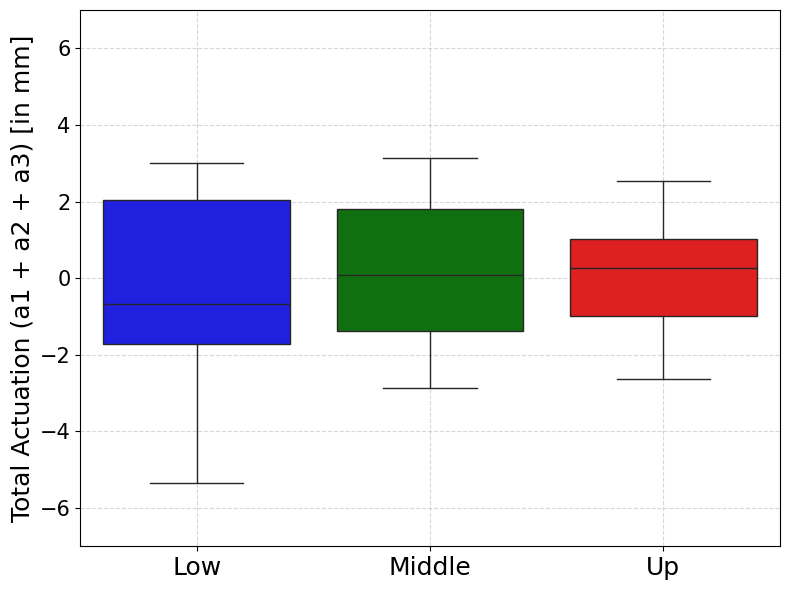

In [67]:
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(8, 6))

sns.boxplot(data=row_sums, orient='v', palette=['blue', 'green', 'red'])
plt.xticks([0, 1, 2], ['Low', 'Middle', 'Up'], fontsize=18)

# increase size of values 
plt.yticks(fontsize=15)
# plt.title('Total Actuation (a1 + a2 + a3) by Section (3 inputs) - absolute difference')
plt.ylabel('Total Actuation (a1 + a2 + a3) [in mm]', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)
# Show in rnage of values
plt.ylim(-7, 7)
plt.tight_layout()
plt.show()

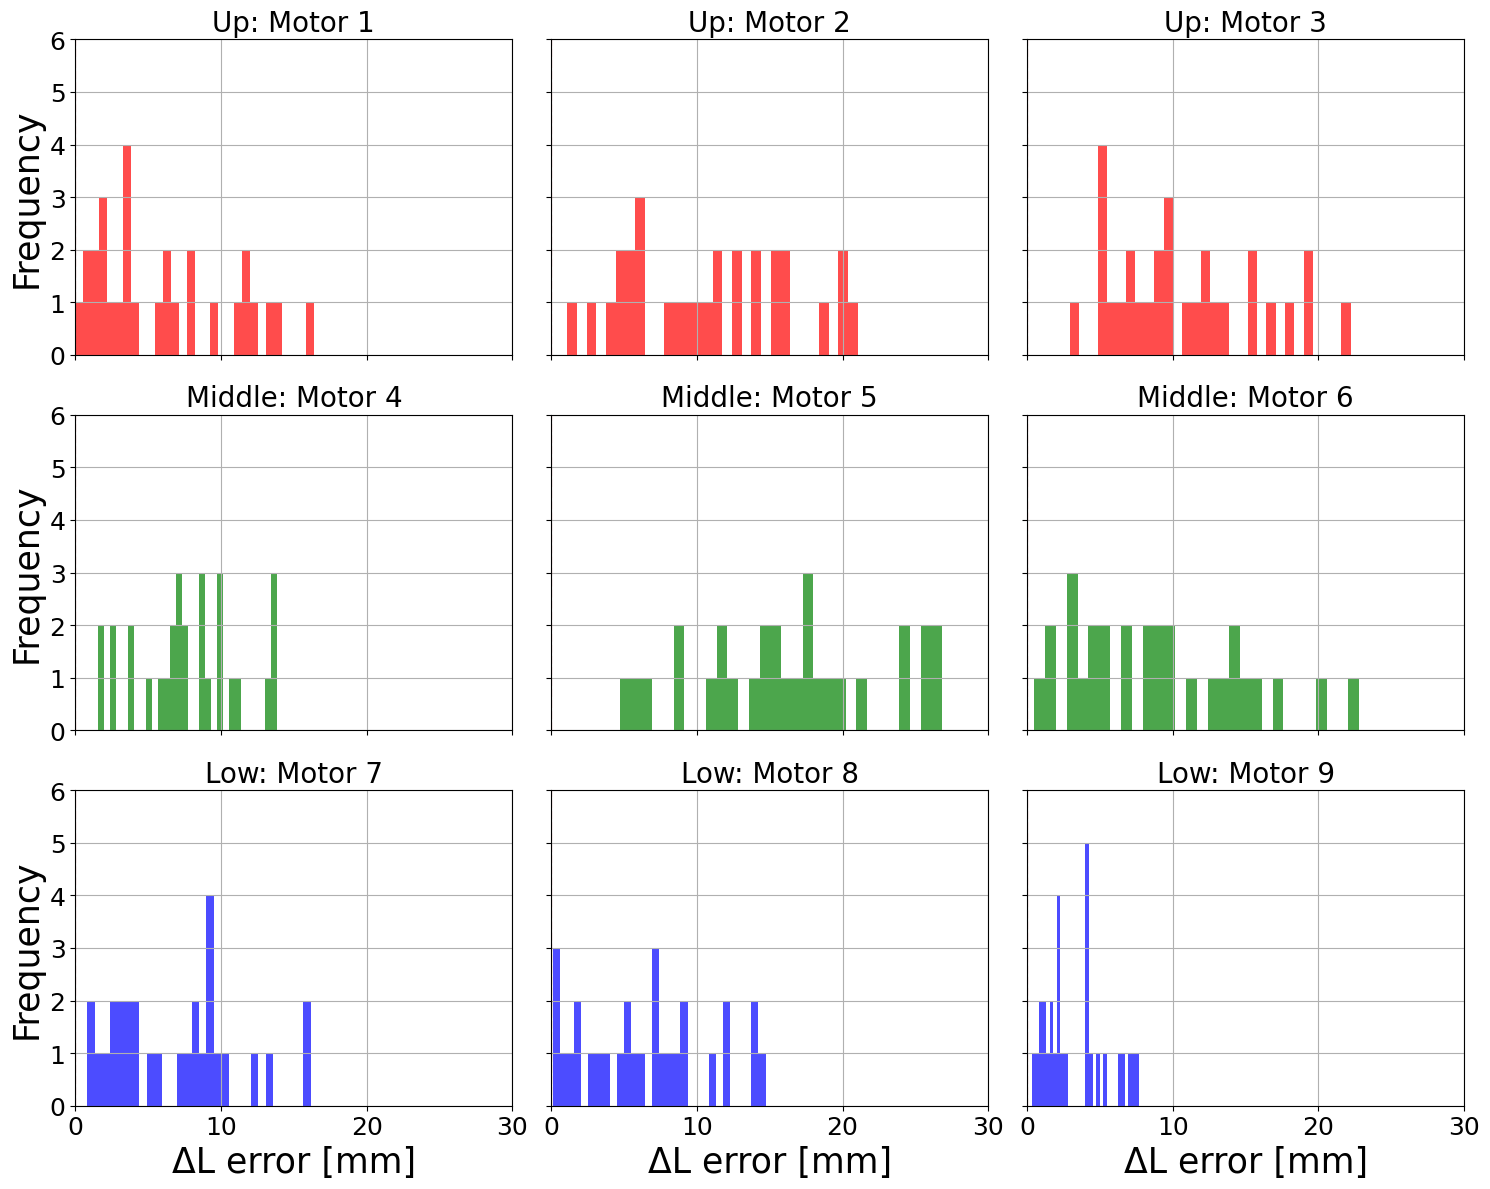

In [68]:
# Convert residuals to delta L values
residuals = diff.reshape(-1, 9)

diff_deltaL = residuals * 0.01534

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

# Define new order: up → middle → low
group_labels = ['Up', 'Middle', 'Low']
group_colors = ['red', 'green', 'blue']

column_indices = [6, 7, 8, 3, 4, 5, 0, 1, 2]

for plot_idx, col_idx in enumerate(column_indices):
    i = plot_idx // 3  # row
    j = plot_idx % 3   # col
    k = plot_idx + 1   # motor number
    ax = axes[i, j]
    
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 6)
    ax.hist(diff_deltaL[:, col_idx], bins=30, alpha=0.7, color=group_colors[i])
    
    group = group_labels[i]
    ax.set_title(f"{group}: Motor {k}", fontsize=20)
    ax.tick_params(axis='both', labelsize=18)

    
    # X-label only on bottom row
    if i == 2:
        ax.set_xlabel("ΔL error [mm]", fontsize=25)

    # Y-label only on first column
    if j == 0:
        ax.set_ylabel("Frequency", fontsize=25)
    
    ax.axvline(0, color='red', linestyle='--')
    ax.grid(True)

plt.tight_layout()
plt.show()
